In [29]:
import os

import numpy as np
import pickle
import time
import pandas as pd

from tqdm.auto import tqdm

import INN
import torch
from IPython.display import clear_output
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


# Parameters

In [31]:
hyperparameter_search_space_boundaries = {
    'n_blocks': [1, 12],
    'n_coupling_network_hidden_layers': [1, 5],
    'n_coupling_network_hidden_nodes': [4, 512 + 256],
}

loss_weights = {
    'bce_factor': 10,
    'dvg_factor': 1,
    'logdet_factor': 1,
    'rcst_factor': 1
}

# Helper Functions

In [32]:
def scale_hyperparameters(hyperparameters):
    return np.array([h * (boundaries[1] - boundaries[0]) + boundaries[0] for h, boundaries in zip(hyperparameters, hyperparameter_search_space_boundaries.values())])

In [33]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
    return total_params

# Load GP-Results

In [34]:
print(f'Loading Results ...')
with open(f'../../hyperparameter_results/INN.pt', 'rb') as file:
    Q, E = pickle.load(file)
print(f'Loaded Results')

GP = GPy.models.GPRegression(Q, E, kernel=GPy.kern.Matern52(3))
GP.optimize(messages=False);

Loading Results ...
Loaded Results


# Inspect GP-Results

In [35]:
Q_scaled = np.round([scale_hyperparameters(q) for q in Q]).astype(int)

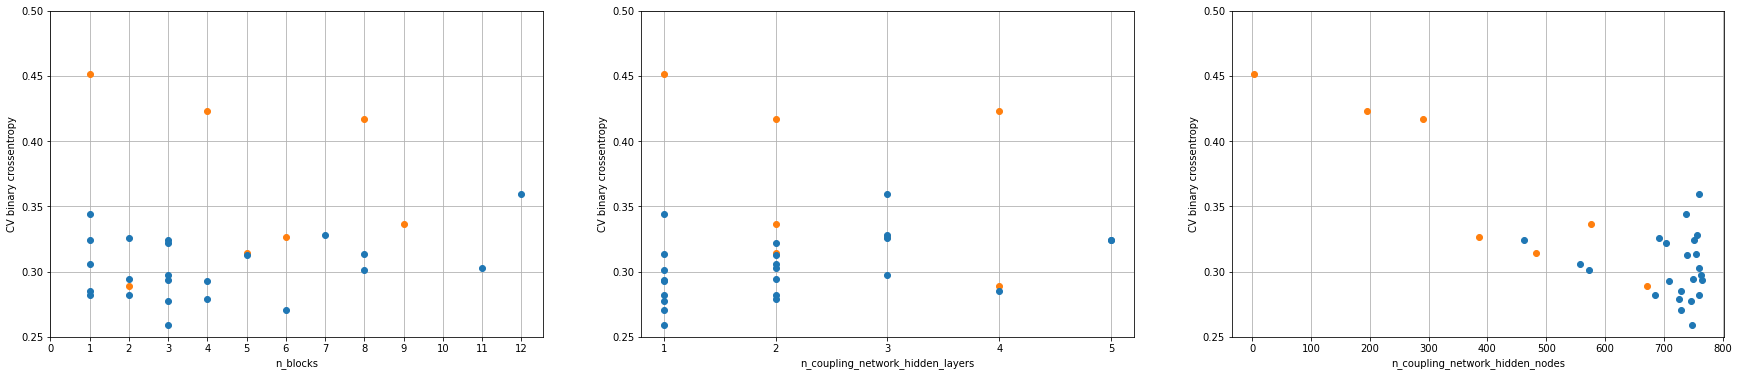

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

for i, key in enumerate(hyperparameter_search_space_boundaries.keys()):
    axes[i].scatter(Q_scaled[:8, i], E[:8], zorder=3, color='tab:orange', label='initial GP')
    axes[i].scatter(Q_scaled[8:, i], E[8:], zorder=3, color='tab:blue', label='trained GP')
    axes[i].set_xlabel(key); axes[i].set_ylabel('CV binary crossentropy')
    axes[i].set_ylim(0.25, 0.5)
    axes[i].grid(zorder=1)

axes[0].set_xticks(range(13));
axes[1].set_xticks(range(1, 6));

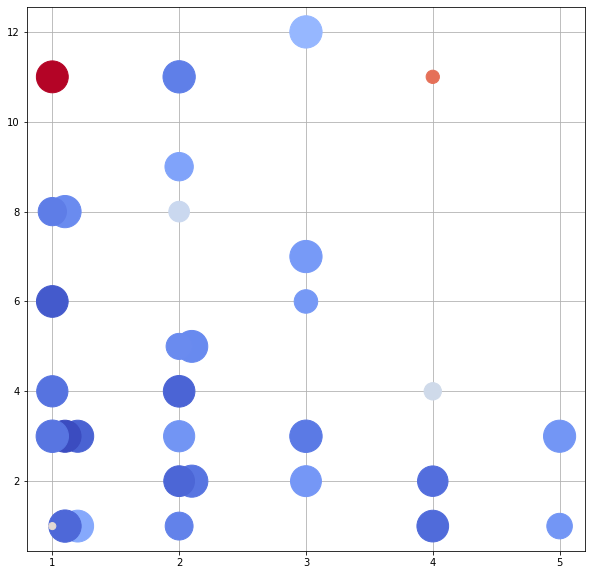

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

y, x, z = Q_scaled.T
e = E[:, 0]

counts = np.zeros((np.max(x)+1, np.max(y)+1))
offset = np.zeros(len(Q))

for i, (x_value, y_value) in enumerate(zip(x, y)):
    counts[x_value, y_value] += 1
    offset[i] += counts[x_value, y_value] - 1


ax.scatter(x[::-1] + offset[::-1]*0.1, y[::-1], s=50 + 1000*(z[::-1] - np.min(z))/(np.max(z) - np.min(z)), color=plt.get_cmap('coolwarm')((E[::-1] - np.min(E))/(np.max(E) - np.min(E))), zorder=3)
ax.set_xticks(range(1, 6)); ax.grid(zorder=1)

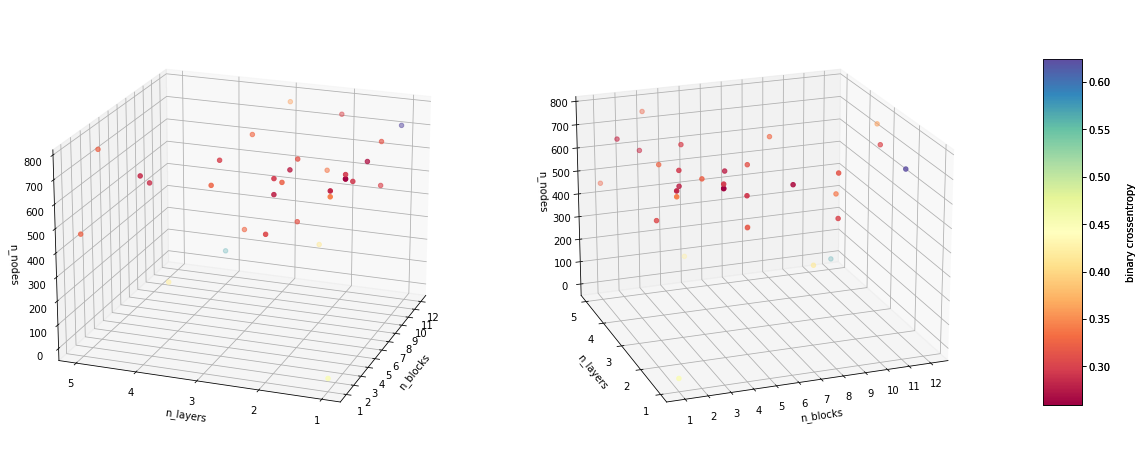

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={'projection':'3d'})
fig.tight_layout(w_pad=10)
fig.subplots_adjust(right=0.75)

offset = 180
for i, angle in enumerate([20+offset, 90-20+offset]):
    x, y, z = Q_scaled.T
    c = E[:, 0]
    
    axes[i].set_xlabel(r'n_blocks'); axes[i].set_ylabel(r'n_layers'); axes[i].set_zlabel(r'n_nodes')
    axes[i].set_xticks(range(13)); axes[i].set_yticks(range(1, 6));
    axes[i].view_init(elev=20., azim=angle)

    img = axes[i].scatter(x, y, z, c=c, cmap=plt.get_cmap('Spectral'))
    colorbar_ax = fig.add_axes([0.8, 0.2, 0.03, 0.6])
    fig.colorbar(img, cax=colorbar_ax, label='\nbinary crossentropy')

# Use INN

In [39]:
with open('../../evaluation_results/predictions/INN.pt', 'rb') as file:
    y_pred = pickle.load(file)

In [40]:
with open('../../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (2313665, 33)
y_train.shape = (2313665, 2)


In [41]:
with open('../../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test.shape = (578417, 33)
y_test.shape = (578417, 2)


In [42]:
binary_crossentropies = [{} for _ in range(5)]

for i in range(5):
    for j, y_label in enumerate(['hosp', 'death']):
        binary_crossentropies[i][y_label] = log_loss(y_test[:, j], y_pred[y_label][i][:, 1])

best_model_index = np.argmin([np.mean([v for v in binary_crossentropies[i].values()]) for i in range(5)])
print(best_model_index)

1


# Evaluation on Test Set

In [43]:
batch_size = 1024

In [44]:
# IMPORTANT: Disable Dropout
with open(f'../../evaluation_results/models/INN_{best_model_index}.pt', 'rb') as file:
    inn = pickle.load(file)

with open(f'../../evaluation_results/loss_history/INN_{best_model_index}.pt', 'rb') as file:
    loss_history = pickle.load(file)

inn.eval();
inn.to(device);

In [45]:
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

In [46]:
X_test_scaled = torch.Tensor(sc_X_train.transform(X_test)).to(device)

n_batches = len(X_test) // batch_size
y_proba_pred = np.empty((0, 2))
z_pred = np.empty((0, 31))

for i_batch in tqdm(range(n_batches + 1)):
    y_proba_pred_new, z_pred_new = inn.forward(X_test_scaled[i_batch * batch_size: (i_batch+1) * batch_size])
    y_proba_pred = np.concatenate([y_proba_pred, y_proba_pred_new.detach().cpu().numpy()], axis=0)
    z_pred = np.concatenate([z_pred, z_pred_new.detach().cpu().numpy()], axis=0)

100%|██████████| 565/565 [00:07<00:00, 76.49it/s]


In [47]:
X_train_scaled_cuda = torch.Tensor(X_train_scaled).to(device)

n_batches = len(X_train) // batch_size
y_train_proba_pred = np.empty((len(X_train), 2))
z_train_pred = np.empty((len(X_train), 31))

for i_batch in tqdm(range(n_batches + 1)):
    y_train_proba_pred_new, z_train_pred_new = inn.forward(X_train_scaled_cuda[i_batch * batch_size: (i_batch+1) * batch_size])
    y_train_proba_pred[i_batch * batch_size: (i_batch+1) * batch_size] = y_train_proba_pred_new.detach().cpu().numpy()
    z_train_pred[i_batch * batch_size: (i_batch+1) * batch_size] = z_train_pred_new.detach().cpu().numpy()

del X_train_scaled_cuda

100%|██████████| 2260/2260 [00:02<00:00, 764.48it/s]


# Convergence

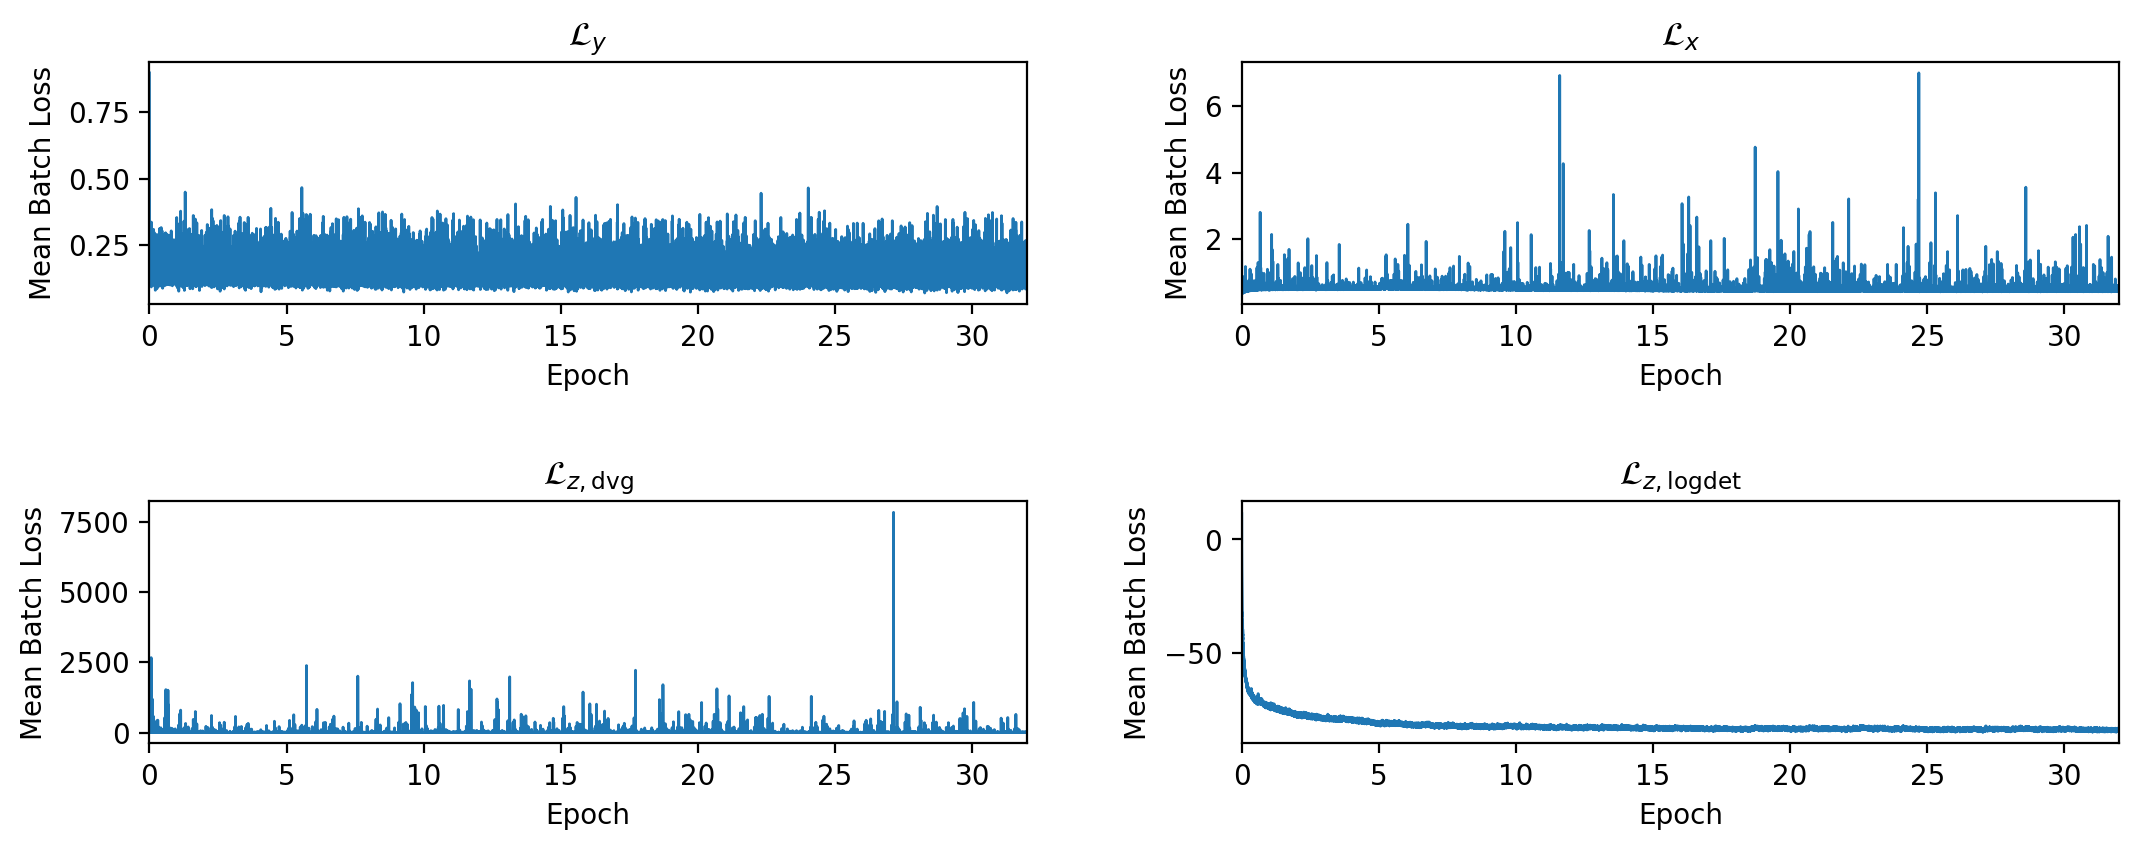

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(16/1.5, 6/1.5), dpi=200)
fig.tight_layout(h_pad=5, w_pad=4)

x_range = np.arange(len(loss_history['bce'])) * 512 / len(X_train)

axes[0, 0].plot(x_range, np.array(loss_history['bce']) / loss_weights['bce_factor'], linewidth=1); axes[0, 0].set_title(r'$\mathcal{L}_{y}$')
axes[0, 1].plot(x_range, np.array(loss_history['rcst']) / loss_weights['rcst_factor'], linewidth=1); axes[0, 1].set_title(r'$\mathcal{L}_{x}$')
axes[1, 0].plot(x_range, np.array(loss_history['dvg']) / loss_weights['dvg_factor'], linewidth=1); axes[1, 0].set_title(r'$\mathcal{L}_{z, \mathrm{dvg}}$')
axes[1, 1].plot(x_range, np.array(loss_history['logdet']) / loss_weights['logdet_factor'], linewidth=1); axes[1, 1].set_title(r'$\mathcal{L}_{z, \mathrm{logdet}}$')

for i in range(2):
    for j in range(2):
        axes[i, j].set_xlim(0, x_range.max());
        axes[i, j].set_xlabel('Epoch'); axes[i, j].set_ylabel('Mean Batch Loss')

# Latent Space

## Distribution

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


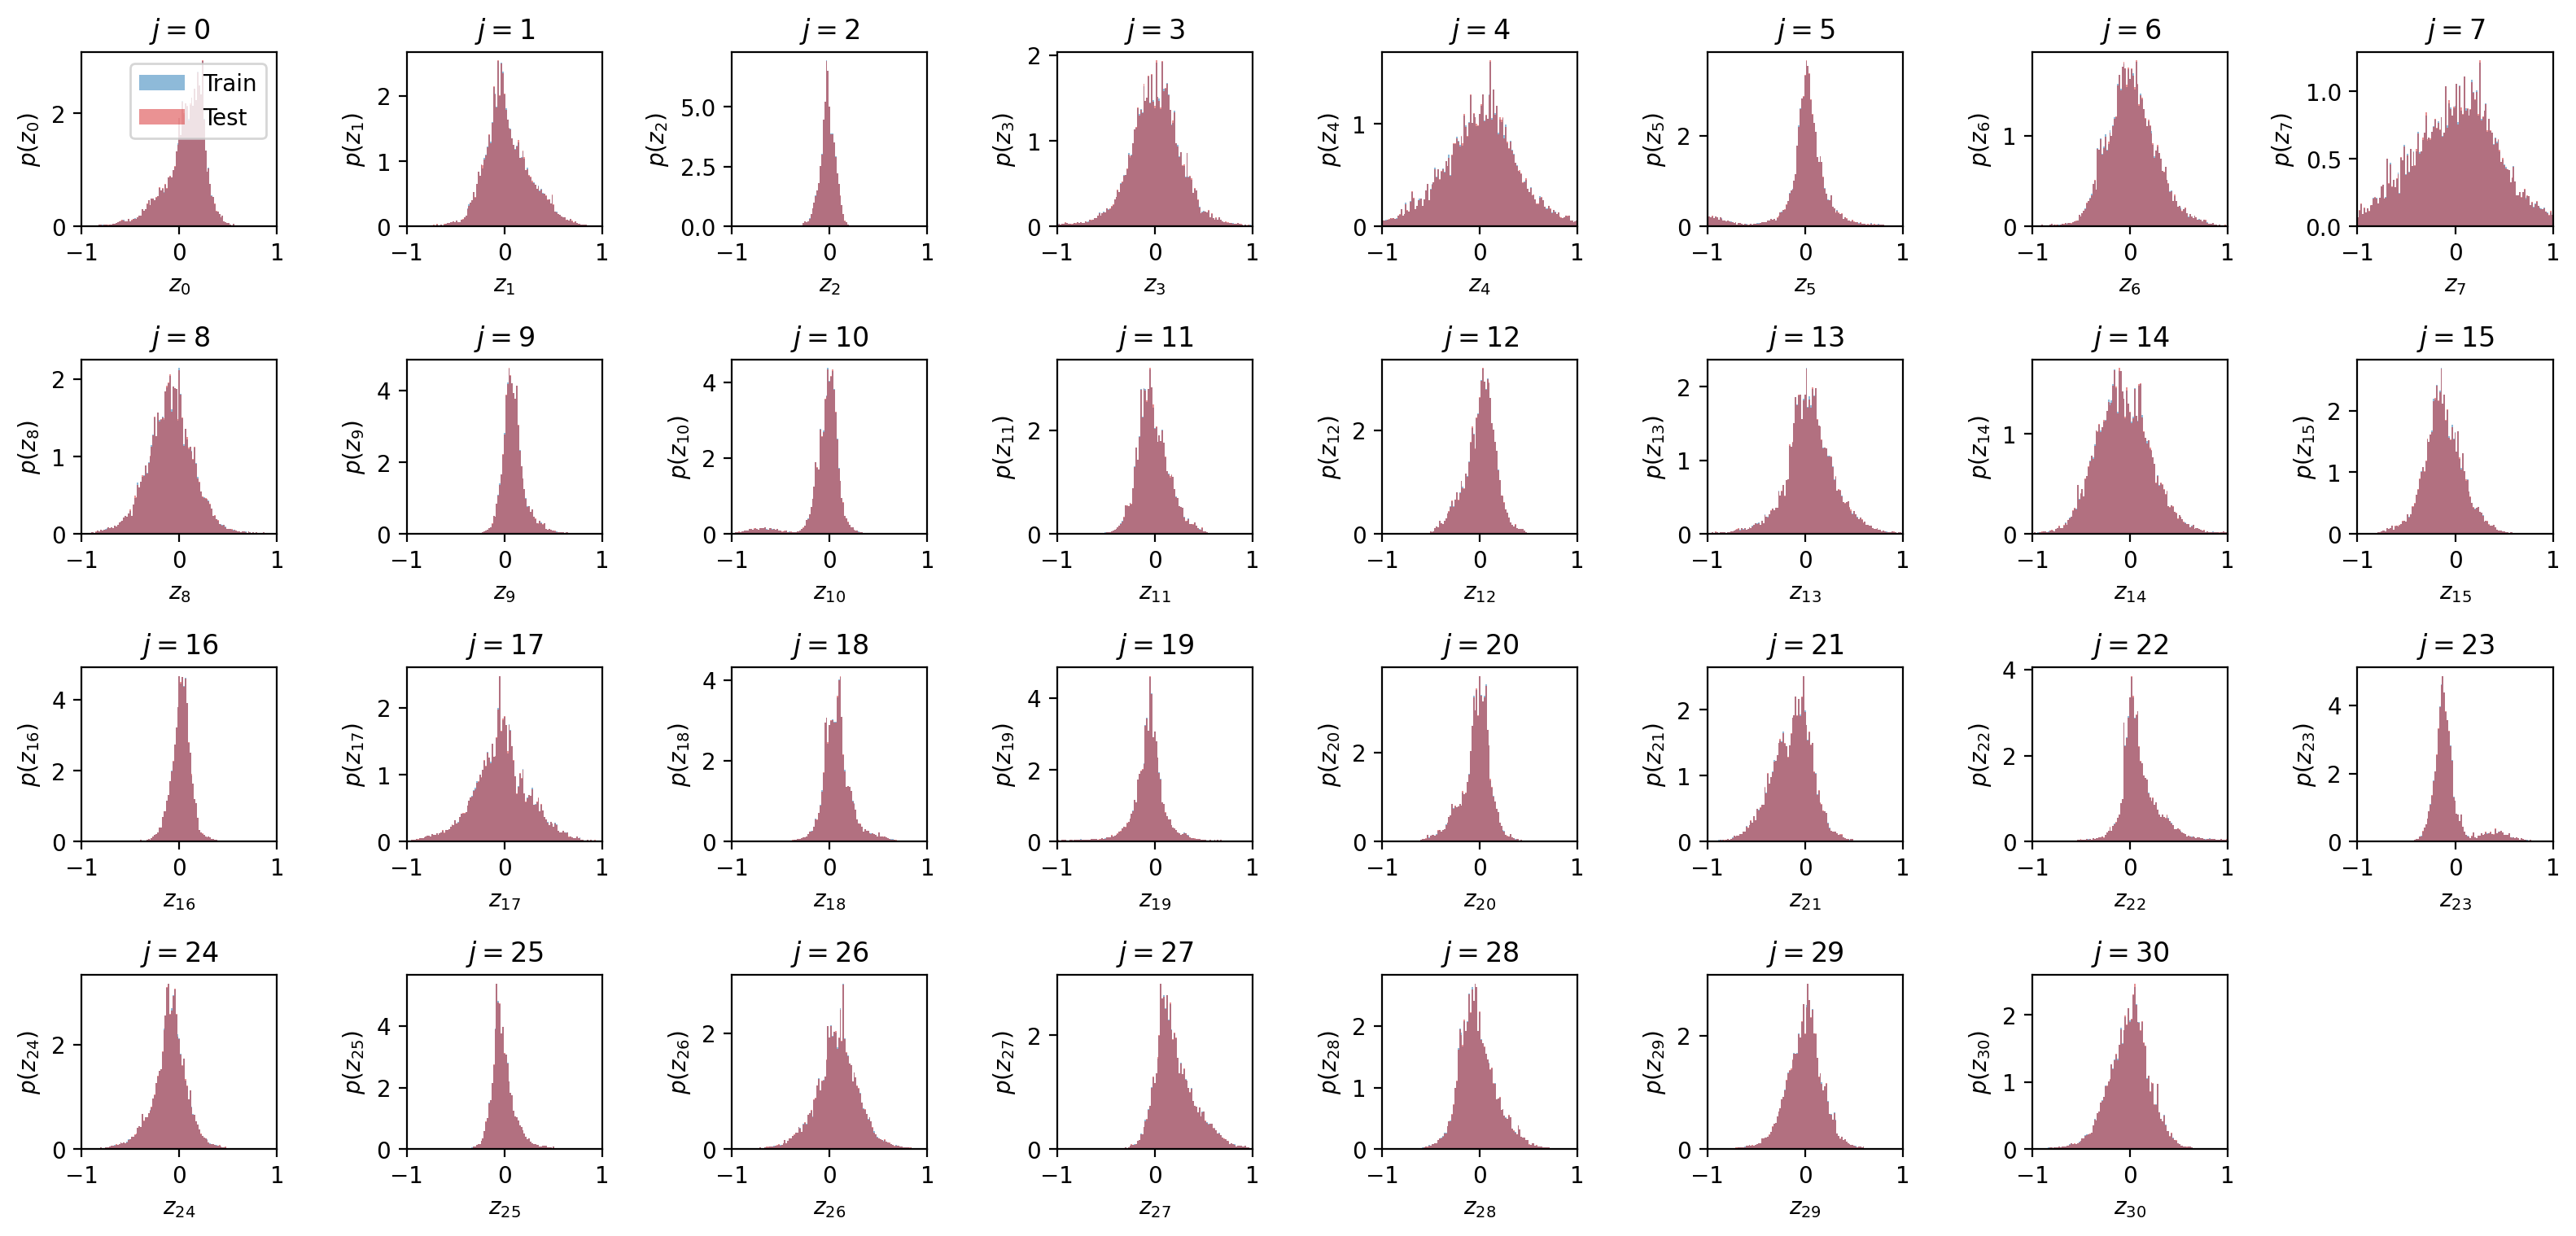

In [49]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(24/1.5, 11/1.5), dpi=200)
# fig.suptitle('Latent Space Distribution (Train vs Test)\n', size=20)
fig.tight_layout(h_pad=3.8, w_pad=2)
bins = np.linspace(-1, 1, 128)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_train_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Train', color='tab:blue')
        axes[i_row][i_col].hist(z_pred[:, i_latent], density=True, bins=bins, alpha=0.5, label='Test', color='tab:red')
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-1, 1); 
        if i_latent == 0: axes[i_row][i_col].legend();

## Indepencence

100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


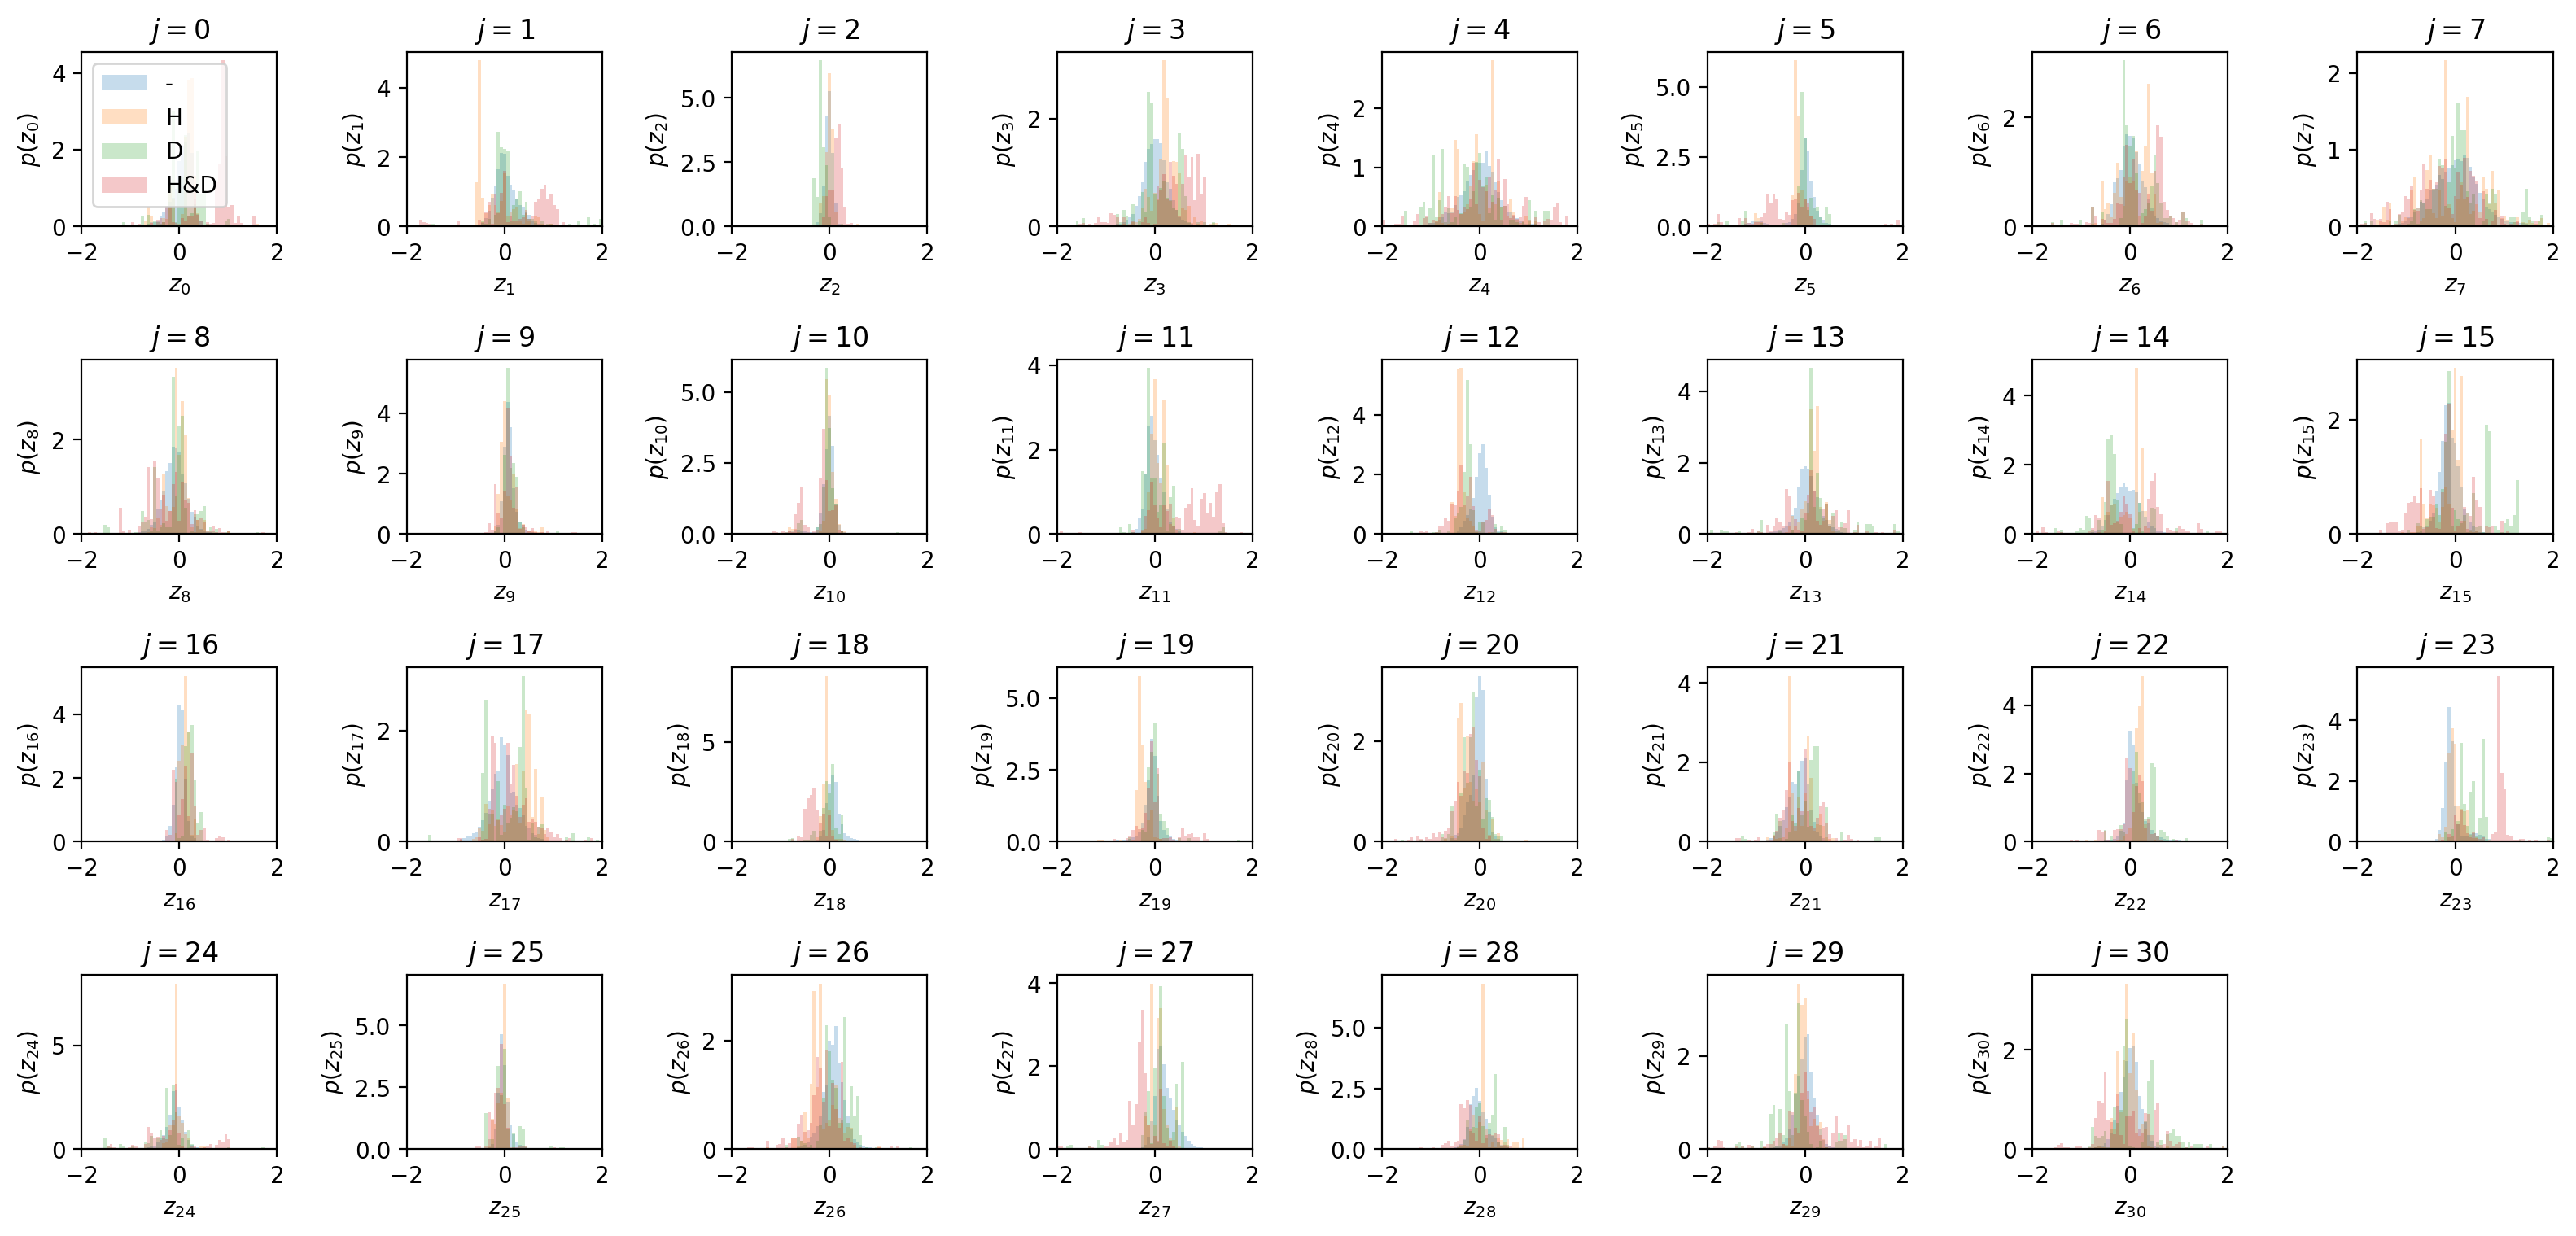

In [50]:
NROWS = 4
NCOLS = int(np.ceil(z_pred.shape[1] / NROWS))

fig, axes = plt.subplots(NROWS, NCOLS, figsize=(24/1.5, 11/1.5), dpi=200)
# fig.suptitle('Latent Space Distribution (Independence of $y$ and $z$)\n', size=20)
fig.tight_layout(h_pad=3.8, w_pad=2)
bins = np.linspace(-2, 2, 64)

for i_row in tqdm(range(NROWS)):
    for i_col in range(NCOLS):
        i_latent = i_row * NCOLS + i_col
        if i_latent >= z_pred.shape[1]:
            axes[i_row][i_col].set_visible(False)
            continue
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] < 0.5, y_proba_pred[:, 1] < 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='-',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] >= 0.5, y_proba_pred[:, 1] < 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='H',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] < 0.5, y_proba_pred[:, 1] >= 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='D',)
        axes[i_row][i_col].hist(z_pred[np.logical_and(y_proba_pred[:, 0] >= 0.5, y_proba_pred[:, 1] >= 0.5), i_latent], density=True, bins=bins, alpha=0.25, label='H&D',)
        axes[i_row][i_col].set_title(f'$j={i_latent}$'); axes[i_row][i_col].set_ylabel(r'$p(z_{' + str(i_latent) + r'}$)'); axes[i_row][i_col].set_xlabel(r'$z_{' + str(i_latent) + r'}$')
        axes[i_row][i_col].set_xlim(-2, 2); 
        if i_latent == 0: axes[i_row][i_col].legend();

In [51]:
keys = ['sex_female','age_0','age_18','age_50','age_65','race_native','race_asian','race_black','race_other','race_native_pacific','race_white','ethnicity_hispanic','case_onset_interval','symptom_status','used_bed_ratio','used_icu_ratio','rural-urban_Continuum Code_2013','urban_influence_code_2013','economic_typology_2015','pop_estimate_2019','less_hs_pct','hs_only_pct','some_college_pct','bachelor_higher_pct','unempl_rate','med_hh_income_19','med_hh_income_pct_state_total_19','poverty_pct_19', 'democrat_20_ratio', 'republican_20_ratio','green_20_ratio','libertarian_20_ratio','other_20_ratio']

def prettyX(X, index=None):
    return pd.DataFrame(X, columns=keys, index=index)

In [52]:
y_zeros = torch.zeros((1, 2)).to(device)
y_h = torch.Tensor([[1, 0]]).to(device)
y_d = torch.Tensor([[0, 1]]).to(device)
y_hd = torch.Tensor([[1, 1]]).to(device)
z_zeros = torch.zeros((1, 31)).to(device)

## Reconstruction: Latent Zeros

In [53]:
x_zeros_pred = inn.inverse(y_zeros, z_zeros).detach().cpu().numpy()
x_h_pred = inn.inverse(y_h, z_zeros).detach().cpu().numpy()
x_d_pred = inn.inverse(y_d, z_zeros).detach().cpu().numpy()
x_hd_pred = inn.inverse(y_hd, z_zeros).detach().cpu().numpy()

In [54]:
x_all = np.concatenate([x_zeros_pred, x_h_pred, x_d_pred, x_hd_pred], axis=0)

In [55]:
prettyX(sc_X_train.inverse_transform(x_all), index=['-', 'H', 'D', 'HD']).T

,-,H,D,HD
sex_female,6.237907e-01,6.435249e-01,6.140272e-01,6.344014e-01
age_0,8.593953e-02,9.662864e-02,8.438452e-02,9.527528e-02
age_18,6.068006e-01,6.595660e-01,5.711132e-01,6.386321e-01
age_50,1.361822e-01,1.296090e-01,1.396982e-01,1.331562e-01
age_65,6.037108e-02,4.681714e-02,7.000553e-02,5.179477e-02
race_native,7.317823e-03,7.540508e-03,7.501877e-03,7.771980e-03
race_asian,3.491639e-02,3.280749e-02,3.573336e-02,3.365187e-02
race_black,9.916709e-02,1.012734e-01,9.764399e-02,1.001990e-01
race_other,2.687995e-02,2.661428e-02,2.651237e-02,2.641701e-02
race_native_pacific,1.747837e-02,1.628848e-02,1.797800e-02,1.680515e-02


## Reconstruction: Encodings

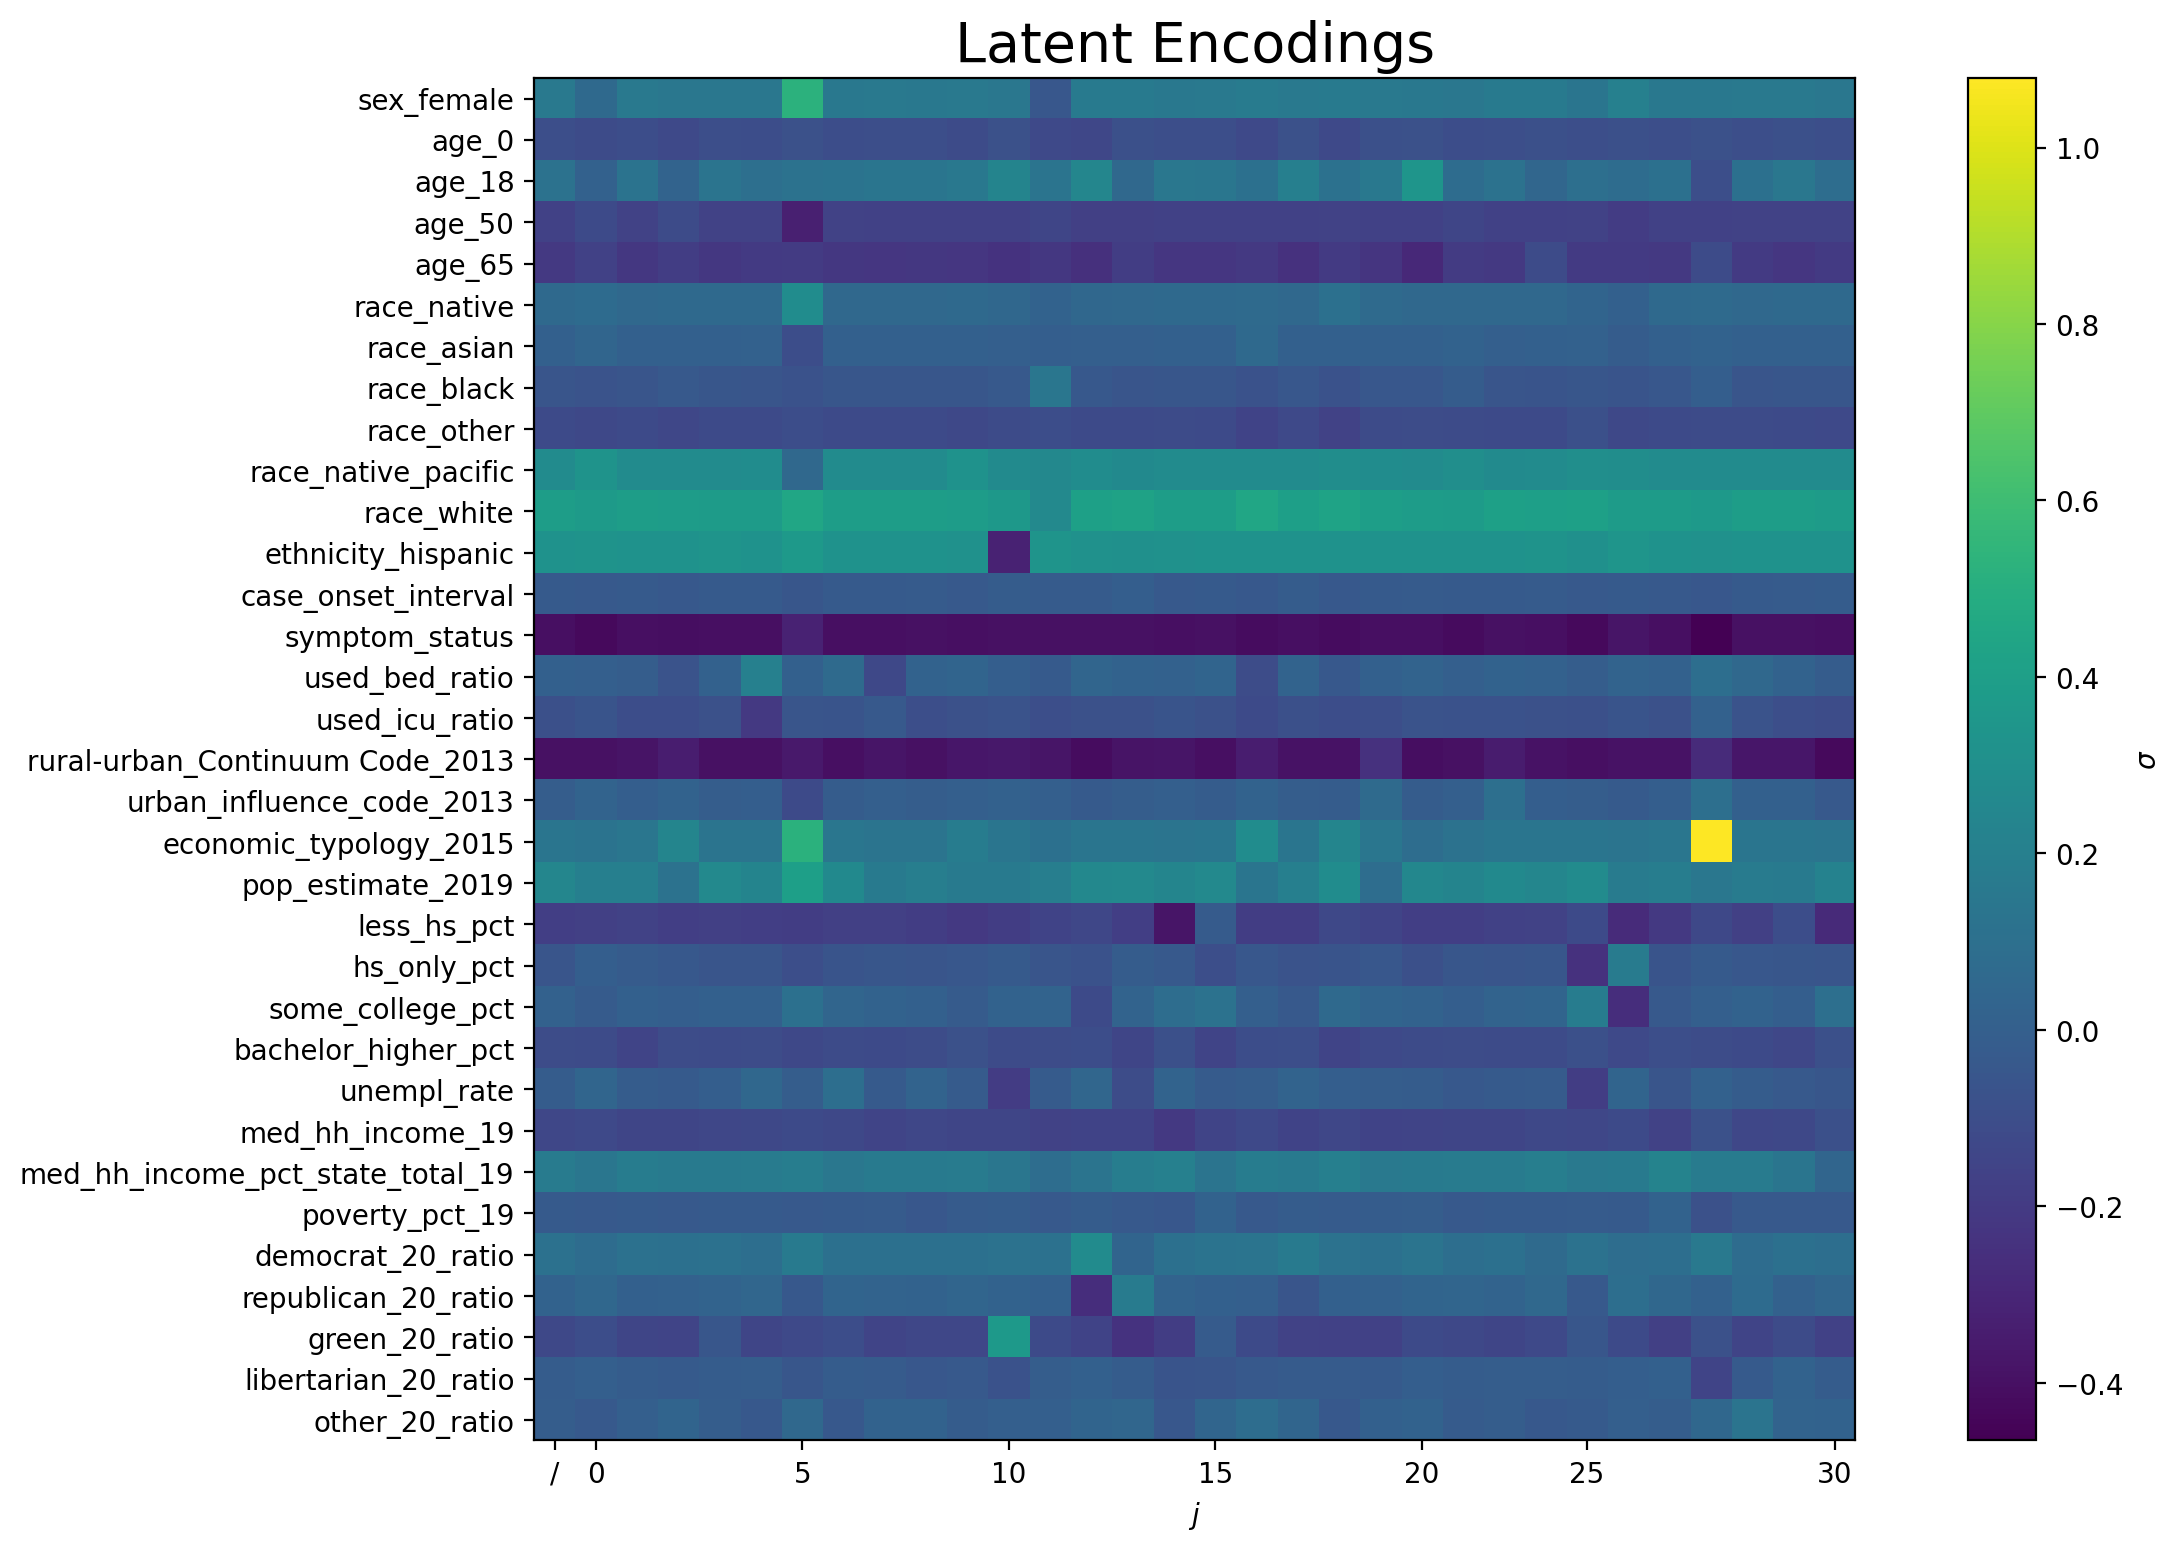

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(18/1.5, 12/1.5), dpi=200)
fig.tight_layout(h_pad=5)
ax.set_title(r'Latent Encodings', size=20);
fig.subplots_adjust(top=0.9)

y_zeros = torch.Tensor([[0, 0]]*32).to(device)
z_onehot = torch.cat([torch.zeros((1, 31)), F.one_hot(torch.arange(0, 31))], dim=0).to(device)
x_onehot = inn.inverse(y_zeros, z_onehot)

img = ax.imshow(x_onehot.detach().cpu().T);
fig.colorbar(img, ax=ax, label='$\sigma$');
ax.set_xlabel('$j$'); #ax.set_title(y_combination_name)
ax.set_yticks(np.arange(len(keys)));
ax.set_xticks([0, 1, 6, 11, 16, 21, 25, 31])
ax.set_xticklabels(['/', 0, 5, 10, 15, 20, 25, 30])
ax.set_yticklabels(keys);

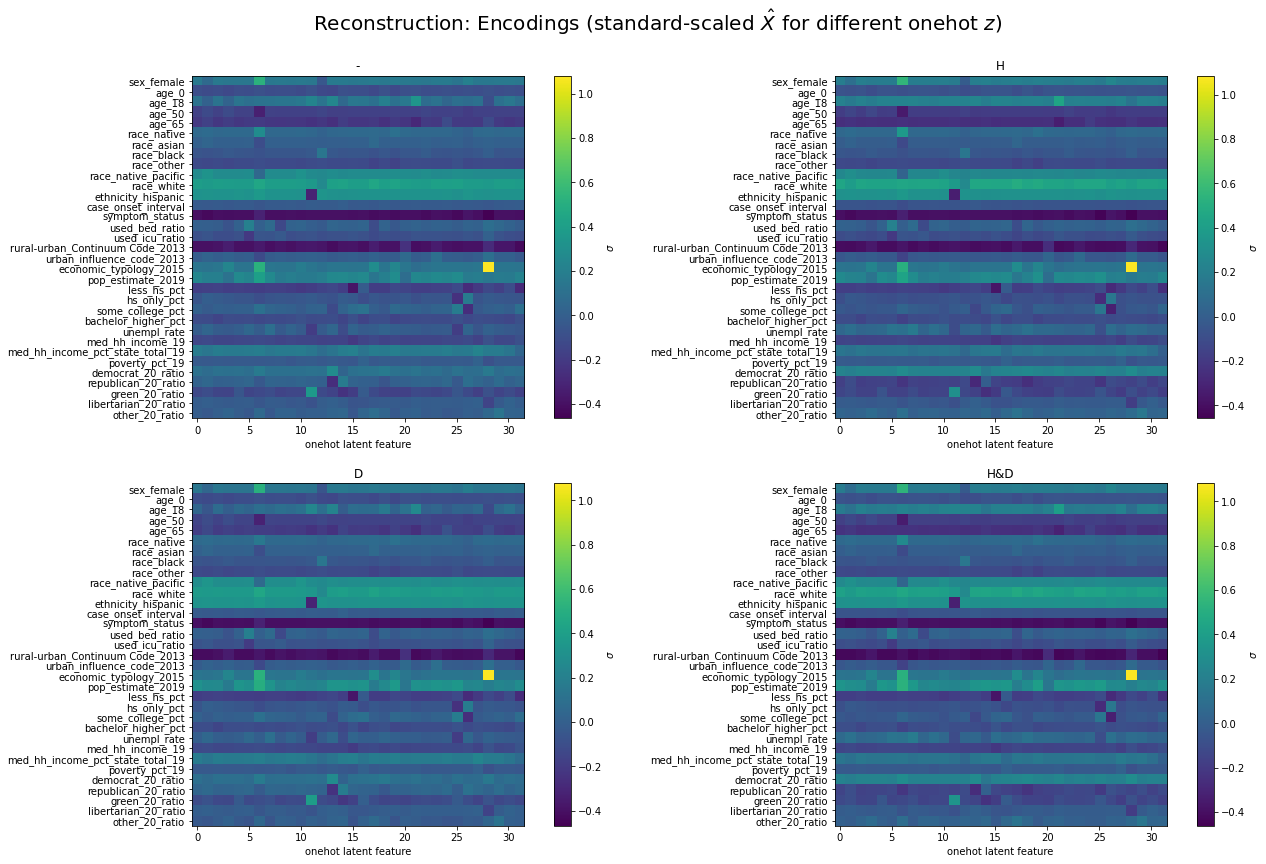

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.tight_layout(h_pad=5)
fig.suptitle(r'Reconstruction: Encodings (standard-scaled $\hat X$ for different onehot $z$)', size=20);
fig.subplots_adjust(top=0.9)

for i, y_combination, y_combination_name in zip(range(4), [[0,0], [1,0], [0,1], [1,1]], ['-', 'H', 'D', 'H&D']):
    y_zeros = torch.Tensor([y_combination]*32).to(device)
    z_onehot = torch.cat([torch.zeros((1, 31)), F.one_hot(torch.arange(0, 31))], dim=0).to(device)
    x_onehot = inn.inverse(y_zeros, z_onehot)

    img = axes[i//2][i%2].imshow(x_onehot.detach().cpu().T);
    fig.colorbar(img, ax=axes[i//2][i%2], label='$\sigma$');
    axes[i//2][i%2].set_xlabel('onehot latent feature'); axes[i//2][i%2].set_title(y_combination_name)
    axes[i//2][i%2].set_yticks(np.arange(len(keys)))
    axes[i//2][i%2].set_yticklabels(keys);

In [30]:
# x_self = {
#     'sex_female': 0,
#     'age_0': 0,
#     'age_18': 1,
#     'age_50': 0,
#     'age_65': 0,
#     'race_native': 0,
#     'race_asian': 0,
#     'race_black': 0,
#     'race_other': 0,
#     'race_native_pacific': 0,
#     'race_white': 1,
#     'ethnicity_hispanic': 0,
#     'case_onset_interval': 0,
#     'symptom_status': 1,
#     'used_bed_ratio': 0.763, #https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Gesundheit/Krankenhaeuser/Tabellen/eckzahlen-krankenhaeuser.html
#     'used_icu_ratio': 2237/2723, #https://www.intensivbetten-deutschland.de/#baden-wuerttemberg
#     'rural-urban_Continuum Code_2013': ,
#     'urban_influence_code_2013': ,
#     'economic_typology_2015': ,
#     'pop_estimate_2019': 548355, #https://de.statista.com/statistik/daten/studie/1172600/umfrage/entwicklung-der-gesamtbevoelkerung-im-rhein-neckar-kreis/
#     'less_hs_pct': (0.035 + 0.286 + 0.235 + 0.04), #https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bildung-Forschung-Kultur/Bildungsstand/Tabellen/bildungsabschluss.html;jsessionid=5F506FE286D82795D2AD411A8EB8435D.live731
#     'hs_only_pct': 25.5,
#     'some_college_pct': ,
#     'bachelor_higher_pct': (0.026 + 0.018 + 0.129 + 0.012),
#     'unempl_rate' 0.04, #https://www.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/arbeitsmarkt-im-land-lebt-weiter-auf/
#     'med_hh_income_19': 25_278, #https://de.wikipedia.org/wiki/Liste_der_Landkreise_nach_Einkommen
#     'med_hh_income_pct_state_total_19': ,
#     'poverty_pct_19': 0.119 #https://paritaet-bw.de/presseportal/pressemitteilungen/armut-baden-wuerttemberg-bei-119-prozent-der-paritaetische-baden-wuerttemberg-fordert-vom-land-sich-weiterhin-gegen-kinderarmut-stark-zu-machen
# }

In [31]:
# IDEA: personal data -> latent representation -> set y = 0 -> inverse -> observe what changed

In [32]:
x_dead = X_test_scaled[y_test[:, 1] == 1][0].reshape(1, -1)

y_dead, z_dead = inn.forward(x_dead)
y_alive = torch.Tensor([[0, 0]]).to(device)

x_reconstructed = inn.inverse(y_dead, z_dead).detach().cpu().numpy()
x_alive = inn.inverse(y_alive, z_dead).detach().cpu().numpy()

x_combined = np.concatenate([x_dead.detach().cpu().numpy(), x_reconstructed, x_alive], axis=0)

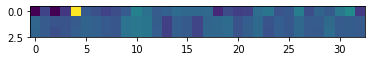

In [33]:
plt.imshow(x_combined)

In [34]:
prettyX(sc_X_train.inverse_transform(x_combined), index=['Dead', 'Reconstructed Dead', 'Reconstructed Alive']).T

,Dead,Reconstructed Dead,Reconstructed Alive
sex_female,-1.773085e-08,5.920192e-01,5.868639e-01
age_0,9.436493e-10,9.930182e-02,1.016182e-01
age_18,-3.247429e-08,4.717149e-01,4.405581e-01
age_50,4.006120e-10,1.413804e-01,1.428751e-01
age_65,1.000000e+00,1.144754e-01,1.290379e-01
race_native,6.187812e-12,8.123498e-03,8.024619e-03
race_asian,1.840840e-10,3.835676e-02,3.899616e-02
race_black,3.477555e-09,9.607172e-02,9.530161e-02
race_other,2.934308e-09,2.688490e-02,2.665055e-02
race_native_pacific,-1.780930e-10,1.807570e-02,1.830153e-02
